In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [9]:
# Step 1: Data Loading and Analysis

In [10]:
# Waymo's official website has four categories of autonomous vehicle driving behavior data
folders = {
    'Aggressive': 'Behavior/Aggressive',
    'Assertive': 'Behavior/Assertive',
    'Conservative': 'Behavior/Conservative',
    'Moderate': 'Behavior/Moderate'
}

In [11]:
# Create a dictionary to store one sample data for each driving style
sample_data = {}
data = {style: [] for style in folders.keys()}

In [12]:
# Read the data and select a sample from each class
for style, folder in folders.items():
    files = [os.path.join(folder, file) for file in os.listdir(folder) if file.endswith('.csv')]
    sample_file = random.choice(files)  # Randomly select a sample
    df = pd.read_csv(sample_file)
    sample_data[style] = df
    # Store all sample data for subsequent analysis
    for file in files:
        df_all = pd.read_csv(file)
        # Handling Inf and NaN Values
        df_all.replace([float('inf'), -float('inf')], float('nan'), inplace=True)
        df_all.dropna(inplace=True)
        data[style].append(df_all)

In [13]:
# Visualization
sns.set(style="whitegrid")

In [14]:
# Plot a time series graph of randomly selected samples
plt.figure(figsize=(12, 12))

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

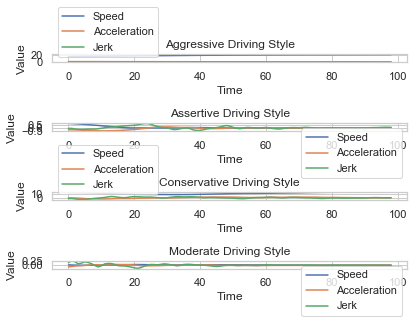

In [15]:
for i, (style, df) in enumerate(sample_data.items(), 1):
    plt.subplot(4, 1, i)
    plt.plot(df['speed'], label='Speed')
    plt.plot(df['acceleration'], label='Acceleration')
    plt.plot(df['jerk'], label='Jerk')
    plt.title(f'{style} Driving Style')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()

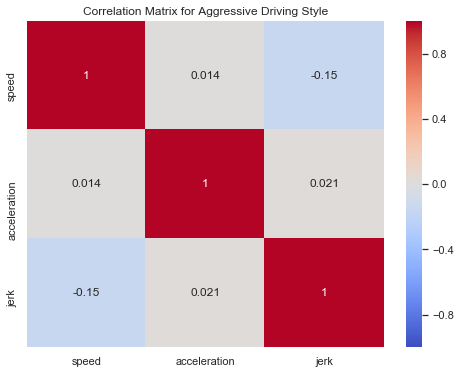

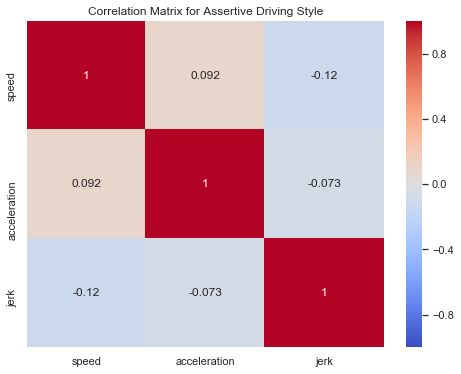

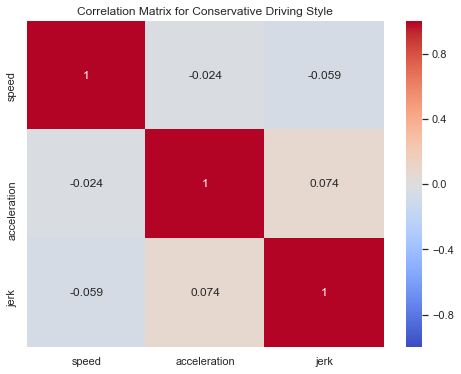

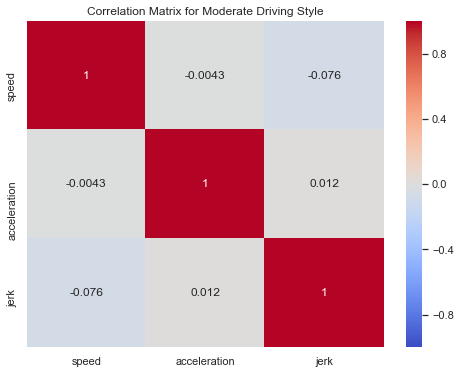

In [16]:
# Plotting the correlation matrix
correlation_matrices = {style: pd.concat(dfs).corr() for style, dfs in data.items()}

for style, corr_matrix in correlation_matrices.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Matrix for {style} Driving Style')
    plt.show()

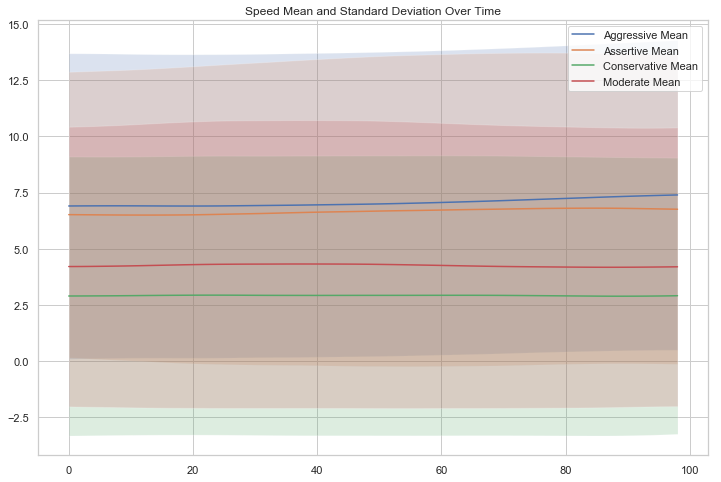

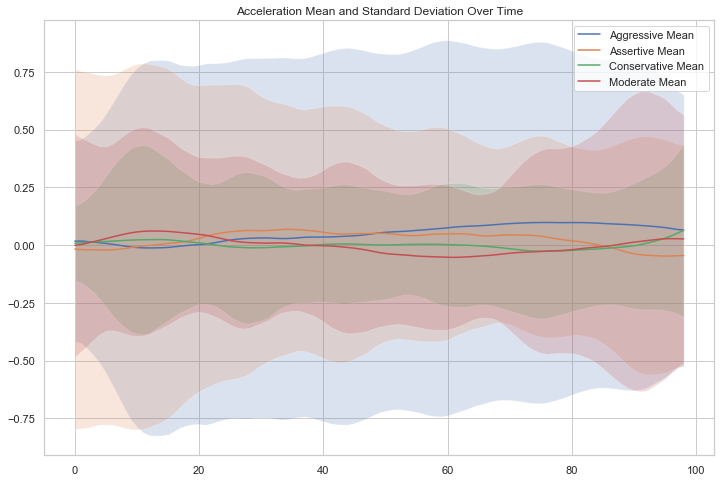

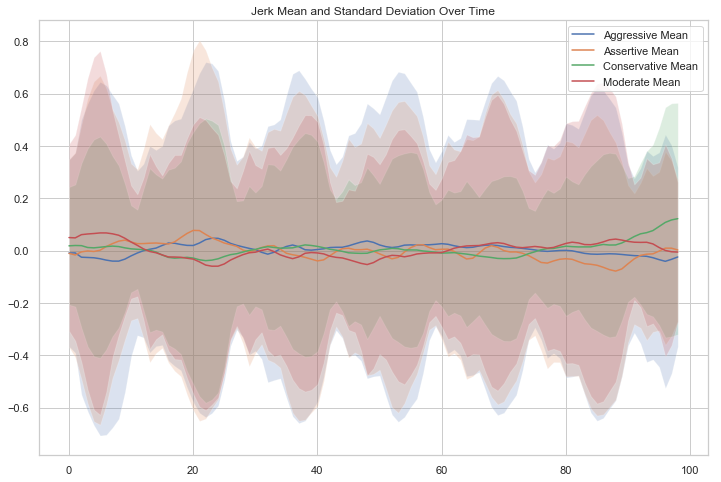

In [17]:
# Plotting the mean and variance of a feature over time
time_series_aggregates = {style: pd.concat(dfs).groupby(level=0).agg(['mean', 'std']) for style, dfs in data.items()}

for feature in ['speed', 'acceleration', 'jerk']:
    plt.figure(figsize=(12, 8))
    for style, ts_aggregate in time_series_aggregates.items():
        plt.plot(ts_aggregate[feature]['mean'], label=f'{style} Mean')
        plt.fill_between(ts_aggregate.index,
                         ts_aggregate[feature]['mean'] - ts_aggregate[feature]['std'],
                         ts_aggregate[feature]['mean'] + ts_aggregate[feature]['std'],
                         alpha=0.2)
    plt.title(f'{feature.capitalize()} Mean and Standard Deviation Over Time')
    plt.legend()
    plt.show()

In [18]:
# PCA Dimensionality Reduction and Visualization
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Merge all data and standardize
all_samples = pd.concat([pd.concat(dfs).assign(Category=style) for style, dfs in data.items()])
features = all_samples[['speed', 'acceleration', 'jerk']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# PCA Dimensionality Reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Category'] = all_samples['Category'].values

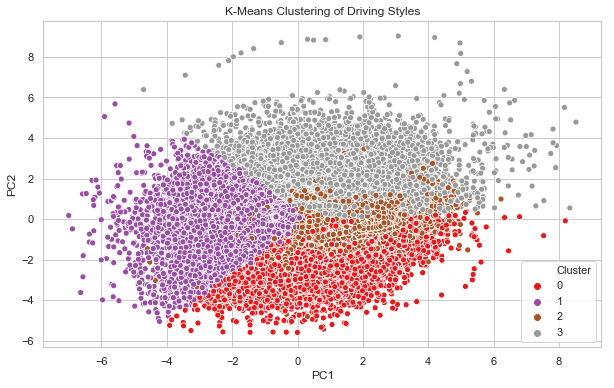

In [19]:
# Cluster analysis
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(scaled_features)

# Add clustering results to pca_df
pca_df['Cluster'] = clusters

# Visualizing PCA and clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set1')
plt.title('K-Means Clustering of Driving Styles')
plt.show()

In [20]:
# Step 2: From the feature distribution point of view, the original features are still not well distributed. Here we need to design the feature extraction process

In [21]:
import os
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import StandardScaler

# Folder Path
folders = {
    'Aggressive': 'Behavior/Aggressive',
    'Assertive': 'Behavior/Assertive',
    'Conservative': 'Behavior/Conservative',
    'Moderate': 'Behavior/Moderate'
}

In [22]:
# Feature extraction function
def extract_features(df):
    features = {}
    for col in df.columns:
        features[f'{col}_mean'] = df[col].mean()
        features[f'{col}_std'] = df[col].std()
        features[f'{col}_max'] = df[col].max()
        features[f'{col}_min'] = df[col].min()
        features[f'{col}_median'] = df[col].median()
        features[f'{col}_quantile25'] = df[col].quantile(0.25)
        features[f'{col}_quantile75'] = df[col].quantile(0.75)
        features[f'{col}_kurtosis'] = kurtosis(df[col])
        features[f'{col}_skewness'] = skew(df[col])

    # Driving behavior characteristics
    acceleration_change_rate = df['acceleration'].diff().abs().mean()
    features['acceleration_change_rate'] = acceleration_change_rate
    num_hard_accelerations = (df['acceleration'] > 2).sum()  # Assume 2 m/s^2 as the rapid acceleration threshold
    features['num_hard_accelerations'] = num_hard_accelerations
    num_hard_brakes = (df['acceleration'] < -2).sum()  # Assume -2 m/s^2 as the rapid deceleration threshold
    features['num_hard_brakes'] = num_hard_brakes
    num_hard_turns = (df['jerk'].abs() > 2).sum()  # Assume 2 m/s^3 as the jerk threshold
    features['num_hard_turns'] = num_hard_turns
    speed_change_rate = df['speed'].diff().abs().mean()
    features['speed_change_rate'] = speed_change_rate

    # Dynamic characteristics
    features['speed_acceleration_cross_correlation'] = df['speed'].corr(df['acceleration'])
    features['acceleration_jerk_cross_correlation'] = df['acceleration'].corr(df['jerk'])
    features['speed_autocorrelation'] = df['speed'].autocorr()
    features['acceleration_autocorrelation'] = df['acceleration'].autocorr()

    return features

In [23]:
# Create a dictionary to store the characteristics of each driving style
features_data = {style: [] for style in folders.keys()}
labels = []

In [24]:
# Read data and extract features
for style, folder in folders.items():
    files = [os.path.join(folder, file) for file in os.listdir(folder) if file.endswith('.csv')]
    for file in files:
        df = pd.read_csv(file)
        # Handling Inf and NaN Values
        df.replace([float('inf'), -float('inf')], float('nan'), inplace=True)
        df.dropna(inplace=True)
        features = extract_features(df)
        features_data[style].append(features)
        labels.append(style)

In [25]:
# Convert feature data into DataFrame
all_features = []
for style, features_list in features_data.items():
    for features in features_list:
        all_features.append(features)

features_df = pd.DataFrame(all_features)
features_df['label'] = labels

In [26]:
# Standardized features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df.drop(columns=['label']))
scaled_features_df = pd.DataFrame(scaled_features, columns=features_df.columns[:-1])
scaled_features_df['label'] = features_df['label']

In [27]:
# Save the extracted features to a CSV file
scaled_features_df.to_csv('extracted_features.csv', index=False)

# Output extracted features
print(scaled_features_df.head())

   acceleration_autocorrelation  acceleration_change_rate  \
0                      0.498586                 -0.540906   
1                      0.443585                 -0.531047   
2                      0.487222                 -0.134280   
3                      0.163600                  1.216664   
4                      0.365330                 -0.025362   

   acceleration_jerk_cross_correlation  acceleration_kurtosis  \
0                             1.601551              -0.315776   
1                            -1.007872              -0.311902   
2                            -0.489046              -0.515263   
3                            -0.332638              -0.434577   
4                            -0.513248              -0.546576   

   acceleration_max  acceleration_mean  acceleration_median  acceleration_min  \
0         -0.023965          -0.179167            -0.292816          0.303045   
1         -0.015652           0.229669             0.106229          0.598445   

In [29]:
# Step3: Perform machine learning modeling

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [31]:
# Reading Data
df = pd.read_csv('extracted_features.csv')

# Separating features and labels
X = df.drop(columns=['label'])
y = df['label']

In [32]:
# Label Encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [33]:
# Divide the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [34]:
# Defining the Model
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Naive Bayes': GaussianNB(),
    'Multilayer Perceptron': MLPClassifier(max_iter=10000)
}

In [35]:
# Train the model and generate a classification report
for name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print(f'Classification Report for {name} on Training Set:\n')
    print(classification_report(y_train, y_train_pred, target_names=label_encoder.classes_, digits=4))
    print('-' * 80)

    print(f'Classification Report for {name} on Test Set:\n')
    print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_, digits=4))
    print('-' * 80)

Classification Report for Logistic Regression on Training Set:

              precision    recall  f1-score   support

  Aggressive     0.8410    0.9392    0.8874      2433
   Assertive     0.6295    0.5085    0.5626       588
Conservative     0.7810    0.6239    0.6937       343
    Moderate     0.7509    0.5467    0.6327       375

 avg / total     0.7932    0.8032    0.7930      3739

--------------------------------------------------------------------------------
Classification Report for Logistic Regression on Test Set:

              precision    recall  f1-score   support

  Aggressive     0.8514    0.9257    0.8870       619
   Assertive     0.6106    0.5433    0.5750       127
Conservative     0.7869    0.5517    0.6486        87
    Moderate     0.6932    0.5980    0.6421       102

 avg / total     0.7954    0.8032    0.7957       935

--------------------------------------------------------------------------------
Classification Report for Support Vector Machine on Training